# Imports

In [4]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [7]:
import json

with open("iclr2024.json", "r", encoding="utf-8") as f:
    data = [json.loads(line) for line in f]

In [6]:
from pathlib import Path

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from datasets import Dataset

MODEL_NAME = "bert-base-uncased"
RANDOM_SEED = 42

## Initial Data Checks

In [8]:
records = data
len(records), records[0]

(7404,
 {'venue': 'ICLR.cc',
  'year': '2024',
  'paper_id': 'cXs5md5wAq',
  'title': 'Modelling Microbial Communities with Graph Neural Networks',
  'abstract': 'Understanding the interactions and interplay of microorganisms is a great challenge with many applications in medical and environmental settings. In this work, we model bacterial communities directly from their genomes using graph neural networks (GNNs). GNNs leverage the inductive bias induced by the set nature of bacteria, enforcing permutation invariance and granting combinatorial generalization. We propose to learn the dynamics implicitly by directly predicting community relative abundance profiles at steady state, thus escaping the need for growth curves. On two real-world datasets, we show for the first time generalization to unseen bacteria and different community structures. \nTo investigate the prediction results more deeply, we created a simulation for flexible data generation and analyze effects of bacteria interac

In [10]:
examples = []

for r in records:
    title = (r.get("title") or "").strip()
    abstract = (r.get("abstract") or "").strip()
    label = r.get("label")

    # Skip if something critical is missing
    if not title or not abstract:
        continue
    if label is None:
        continue

    text = f"{title} {abstract}".strip()
    examples.append({"text": text, "label": int(label)})

len(examples)

7404

In [11]:
import collections

label_counts = collections.Counter(e["label"] for e in examples)
label_counts, {k: v / len(examples) for k, v in label_counts.items()}

(Counter({0: 5143, 1: 2261}), {0: 0.69462452728255, 1: 0.30537547271745})

# Building Model and Making Training Data

## Training, Validation, and Test Splits

In [12]:
def make_splits(examples, test_size=0.2, val_size=0.2, seed=RANDOM_SEED):
    texts = [e["text"] for e in examples]
    labels = [e["label"] for e in examples]

    X_train, X_temp, y_train, y_temp = train_test_split(
        texts, labels,
        test_size=test_size,
        random_state=seed,
        stratify=labels,
    )

    val_ratio = val_size / (1.0 - test_size)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp,
        test_size=1 - val_ratio,
        random_state=seed,
        stratify=y_temp,
    )

    def to_hf(texts, labels):
        return Dataset.from_dict({"text": texts, "label": labels})

    return (
        to_hf(X_train, y_train),
        to_hf(X_val, y_val),
        to_hf(X_test, y_test),
    )

train_ds, val_ds, test_ds = make_splits(examples)
len(train_ds), len(val_ds), len(test_ds)

(5923, 370, 1111)

## Set up tokenizer and tokenize data

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=256,
    )

tokenized_train = train_ds.map(tokenize, batched=True)
tokenized_val = val_ds.map(tokenize, batched=True)
tokenized_test = test_ds.map(tokenize, batched=True)

for ds in [tokenized_train, tokenized_val, tokenized_test]:
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/5923 [00:00<?, ? examples/s]

Map:   0%|          | 0/370 [00:00<?, ? examples/s]

Map:   0%|          | 0/1111 [00:00<?, ? examples/s]

## Build BERT

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # softmax for positive class (label=1)
    exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
    probs = exp_logits[:, 1] / exp_logits.sum(axis=1)

    preds = (probs >= 0.5).astype(int)

    metrics = {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds),
    }
    try:
        metrics["auroc"] = roc_auc_score(labels, probs)
    except ValueError:
        metrics["auroc"] = float("nan")
    return metrics

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Create Trainer and Define Arguments

In [20]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="outputs/bert_acceptance_baseline",
    eval_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=False,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2502836660.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# Fine-Tuning

In [16]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [21]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Auroc
1,0.589900,0.611013,0.708108,0.114754,0.525464
2,0.558300,0.611983,0.710811,0.130081,0.598395
3,0.570400,0.589186,0.708108,0.156250,0.628973


TrainOutput(global_step=2223, training_loss=0.6005442641202898, metrics={'train_runtime': 194.3256, 'train_samples_per_second': 91.439, 'train_steps_per_second': 11.44, 'total_flos': 2337610171345920.0, 'train_loss': 0.6005442641202898, 'epoch': 3.0})

# Evaluation

In [22]:
test_metrics = trainer.evaluate(tokenized_test)
test_metrics

{'eval_loss': 0.5868611931800842,
 'eval_accuracy': 0.7092709270927092,
 'eval_f1': 0.178117048346056,
 'eval_auroc': 0.6286930472129244,
 'eval_runtime': 3.7537,
 'eval_samples_per_second': 295.978,
 'eval_steps_per_second': 18.648,
 'epoch': 3.0}

In [23]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

preds_output = trainer.predict(tokenized_test)
logits = preds_output.predictions
labels = preds_output.label_ids

exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))
probs = exp_logits[:, 1] / exp_logits.sum(axis=1)
y_pred = (probs >= 0.5).astype(int)

print(confusion_matrix(labels, y_pred))
print(classification_report(labels, y_pred, digits=3))

[[753  19]
 [304  35]]
              precision    recall  f1-score   support

           0      0.712     0.975     0.823       772
           1      0.648     0.103     0.178       339

    accuracy                          0.709      1111
   macro avg      0.680     0.539     0.501      1111
weighted avg      0.693     0.709     0.627      1111



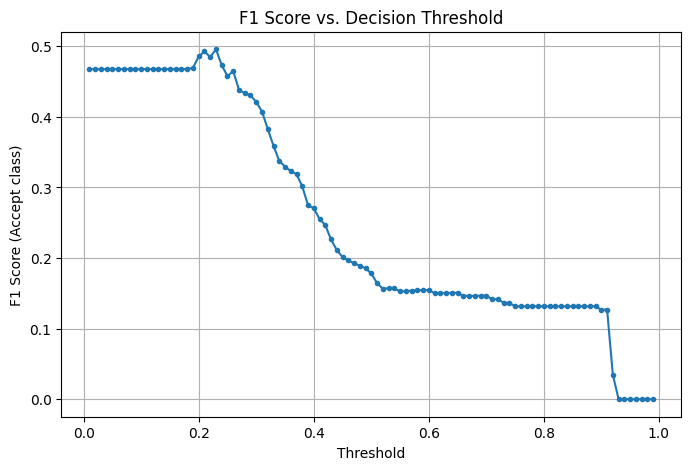

(np.float64(0.23), 0.49579045837231056)

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

thresholds = np.linspace(0.01, 0.99, 99)

f1_scores = []
for t in thresholds:
    preds = (probs >= t).astype(int)
    f1 = f1_score(labels, preds)
    f1_scores.append(f1)

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='o', markersize=3)
plt.xlabel("Threshold")
plt.ylabel("F1 Score (Accept class)")
plt.title("F1 Score vs. Decision Threshold")
plt.grid(True)
plt.show()

best_t = thresholds[np.argmax(f1_scores)]
best_f1 = max(f1_scores)
best_t, best_f1


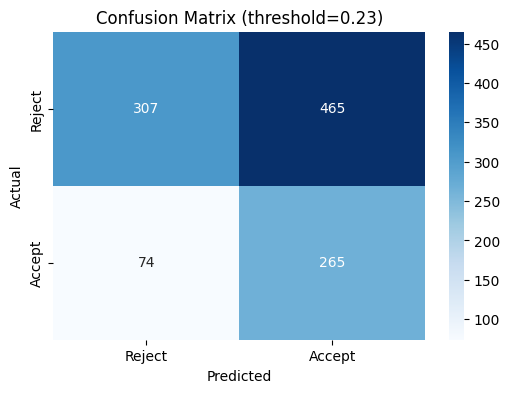

In [25]:
import seaborn as sns

best_preds = (probs >= best_t).astype(int)  # use tuned threshold
cm = confusion_matrix(labels, best_preds)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Reject", "Accept"],
            yticklabels=["Reject", "Accept"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (threshold={best_t:.2f})")
plt.show()


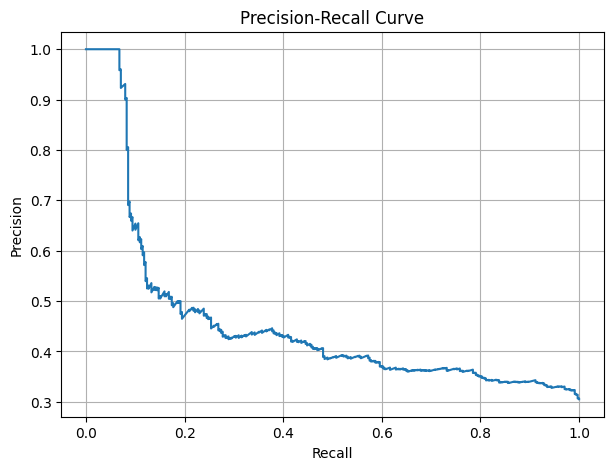

In [26]:
from sklearn.metrics import precision_recall_curve

prec, rec, th = precision_recall_curve(labels, probs)

plt.figure(figsize=(7,5))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()
